<a href="https://colab.research.google.com/github/ArjunHanda/cancer-cell-detection/blob/main/Copy_of_cancer_cell_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Data


upload kaggle.json

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:

!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.20G/5.20G [02:27<00:00, 42.6MB/s]
100% 5.20G/5.20G [02:27<00:00, 37.8MB/s]


In [ ]:
!unzip /content/skin-cancer-mnist-ham10000.zip

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: h

# Importing libraries

In [ ]:
# import system libs
import os
import time
import shutil
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_crossentropy

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

#print ('modules loaded')


# Reading and analysing data


In [ ]:
metadata = pd.read_csv("/content/HAM10000_metadata.csv")

In [ ]:
metadata

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [ ]:
data = pd.read_csv("/content/hmnist_28_28_RGB.csv")

In [ ]:
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [ ]:
Label = data['label']

In [ ]:
Data = data.drop(columns=["label"])

In [ ]:
folder1 = '/content/HAM10000_images_part_1'
folder2 = '/content/HAM10000_images_part_2'

In [ ]:
data["label"].value_counts()

4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: label, dtype: int64

*From this we can infer there is an imalance in our data
To handle this we will perform oversampling, which basically balances the class distribution in our dataset.
It will increase the number of instances in the minority classes to match the majority class.*


In [ ]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler()
Data, Label  = oversample.fit_resample(Data, Label)
Data = np.array(Data).reshape(-1, 28, 28, 3)
print('Shape of Data :', Data.shape)

Shape of Data : (46935, 28, 28, 3)


In [ ]:
Label = np.array(Label)
#Label = np.append(Label, 7) #to add the "uk" condition #this leads to inconsistent samples further in the train_test_split
Label

array([2, 2, 2, ..., 6, 6, 6])

*Convert abbreviations of cancer names to it's words*

In [ ]:
classes = {4: ('nv', ' melanocytic nevi'),
           6: ('mel', 'melanoma'),
           2 :('bkl', 'benign keratosis-like lesions'),
           1:('bcc' , ' basal cell carcinoma'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'),
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           3: ('df', 'dermatofibroma')
           } #7: ('uk', 'unknown')

*Splitting Data for training and testing.*

In [ ]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(Data , Label , test_size = 0.20 , random_state = 50)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(37548, 28, 28, 3)
(37548,)
(9387, 28, 28, 3)
(9387,)


In [ ]:
#Converting labels to categorical
from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
datagen = ImageDataGenerator(rescale=(1./255) #rescaling is done to reduce the pixel values to [0,1]. This is a common step for neural networks and brings the values into a suitable range for training
                             ,rotation_range=10 #this applies random rotations upto 10 degrees in either direction. This makes the training data better and helps the model become robust.
                             ,zoom_range = 0.1 #the image will be zoomed in or out by 10%. This helps the model to learn to recognize objects from different perspectives and scales.
                             ,width_shift_range=0.1 #these both control Vertical and horizontal ships of the images upto 10%. This helps the model to handle variations of objects in the images.
                             ,height_shift_range=0.1)

testgen = ImageDataGenerator(rescale=(1./255)) # This ensures that the test data is pre-processed in the same way as the training data.

In [ ]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy' #monitors the validation accuracy
                                            , patience = 2 #determines how many consecutive epochs of no improvement in the monitored metric (val_accuracy in this case) will trigger the learning rate reduction.
                                            , verbose=1 #this means that Messages about learning rate reduction will be printed to the console.
                                            ,factor=0.5 # This specifies how much the learning rate should be reduced when the specified condition is met. In our case learning rate will be halved
                                            , min_lr=0.00001) #This sets the lower bound for the learning rate.

# Model Structure

In [ ]:
model = keras.models.Sequential()

# Create Model Structure
model.add(keras.layers.Input(shape=[28, 28, 3])) #this layer defines the shape of the input data. Image is of size 28x28 pixels and 3 colour channels (RGB)
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')) #convulutional layers extract features.
model.add(keras.layers.MaxPooling2D()) #these layers reduce the spatial dimensions of the feature maps while retaining the most important information. They help make the network more robust to variations in the input.
model.add(keras.layers.BatchNormalization())# these layers normalize the activations of the previous layer.

model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Flatten()) #flattens the 2D feature maps from convolutional layers into a 1D vector.
model.add(keras.layers.Dropout(rate=0.2)) #this layer prevents overfitting by randomly deactivating a fraction of neurons.
model.add(keras.layers.Dense(units=256, activation='relu', kernel_initializer='he_normal')) #these layers recieve the flattened feature vector and provides outputs for each classes.
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.L1L2()))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=7, activation='softmax', kernel_initializer='glorot_uniform', name='classifier')) # this is the ouptput layer which classifies output into class probabilities.
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 14, 14, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0

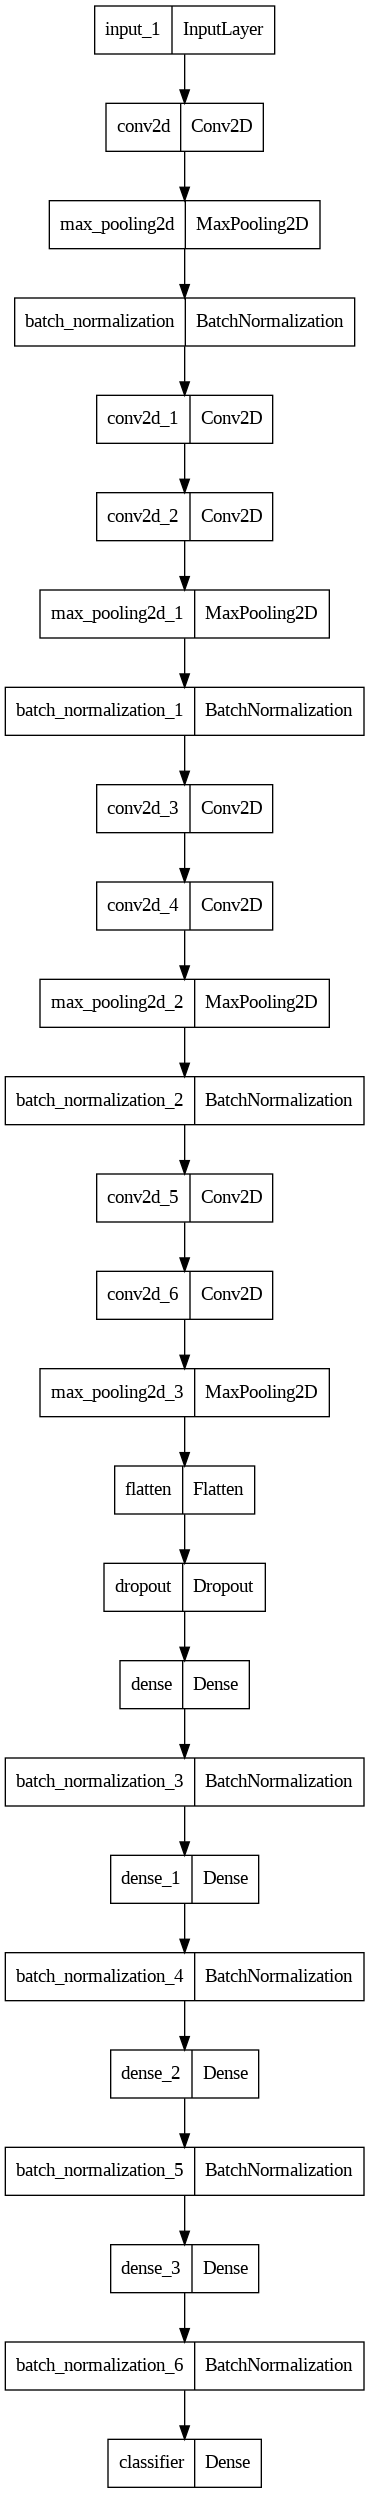

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_summary.png')

# Training the model

In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs=25,
                    batch_size=128,
                    validation_data=(X_test , y_test),
                    callbacks=[learning_rate_reduction])

Epoch 1/25
294/294 [==============================] - 26s 25ms/step - loss: 1.1450 - accuracy: 0.5865 - val_loss: 0.8704 - val_accuracy: 0.6740 - lr: 0.0010
Epoch 2/25
294/294 [==============================] - 5s 18ms/step - loss: 0.4548 - accuracy: 0.8449 - val_loss: 0.3908 - val_accuracy: 0.8580 - lr: 0.0010
Epoch 3/25
294/294 [==============================] - 5s 17ms/step - loss: 0.2662 - accuracy: 0.9095 - val_loss: 0.2326 - val_accuracy: 0.9222 - lr: 0.0010
Epoch 4/25
294/294 [==============================] - 6s 20ms/step - loss: 0.1802 - accuracy: 0.9397 - val_loss: 0.2148 - val_accuracy: 0.9270 - lr: 0.0010
Epoch 5/25
294/294 [==============================] - 5s 17ms/step - loss: 0.1405 - accuracy: 0.9532 - val_loss: 0.1988 - val_accuracy: 0.9267 - lr: 0.0010
Epoch 6/25
294/294 [==============================] - 6s 20ms/step - loss: 0.1029 - accuracy: 0.9654 - val_loss: 0.1426 - val_accuracy: 0.9514 - lr: 0.0010
Epoch 7/25
294/294 [==============================] - 5s 17ms/s

# Training history

In [ ]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

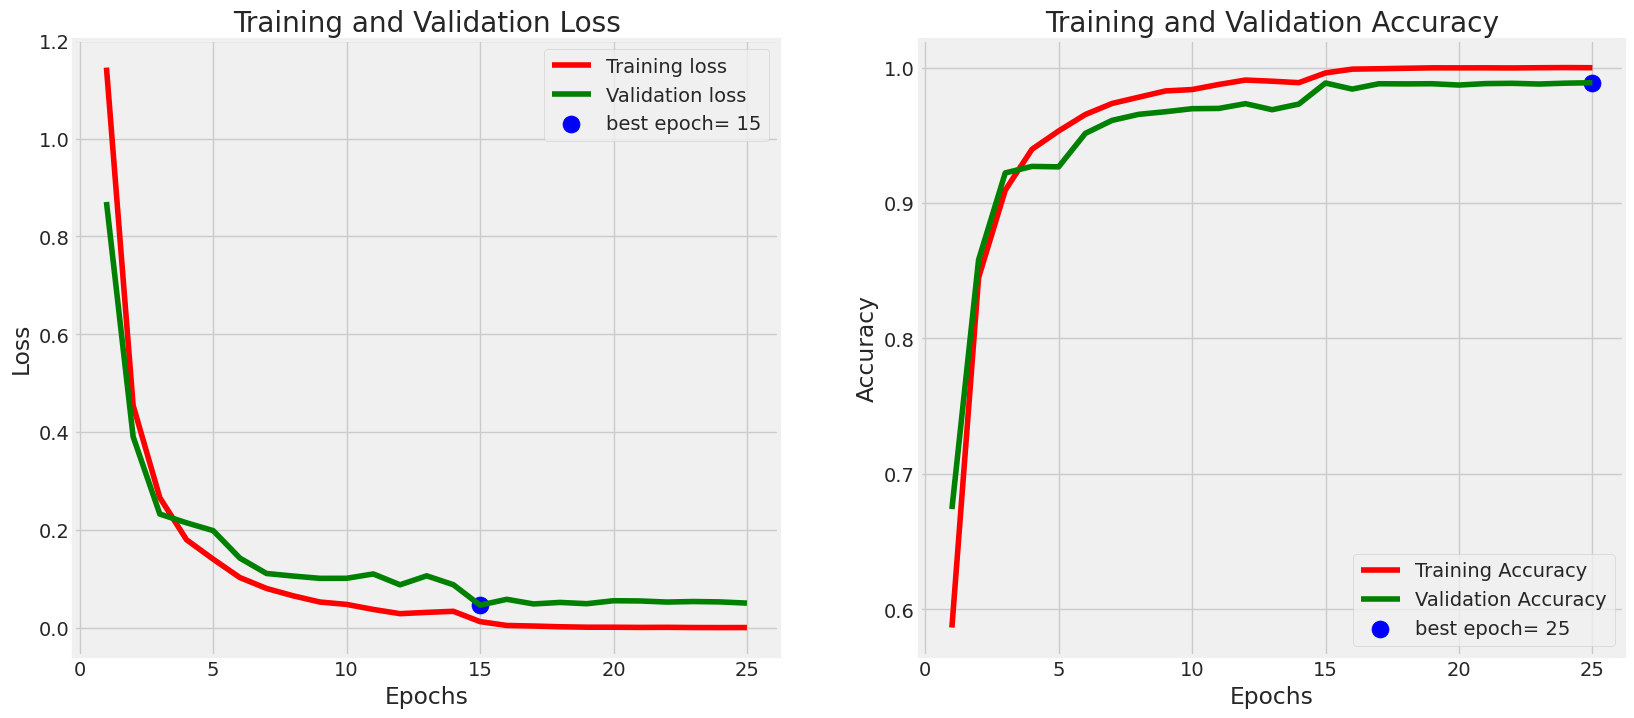

In [ ]:
plot_training(history)

In [ ]:
train_score = model.evaluate(X_train, y_train, verbose= 1)
test_score = model.evaluate(X_test, y_test, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

294/294 [==============================] - 2s 6ms/step - loss: 0.0507 - accuracy: 0.9888
Train Loss:  0.00019567747949622571
Train Accuracy:  1.0
--------------------
Test Loss:  0.050705283880233765
Test Accuracy:  0.9888142943382263


*for confusion matrix and various scores*

In [ ]:
y_true = np.array(y_test)
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred , axis=1)
y_true = np.argmax(y_true , axis=1)

294/294 [==============================] - 1s 3ms/step


In [ ]:
classes_labels = []
for key in classes.keys():
    classes_labels.append(key)

print(classes_labels)

[4, 6, 2, 1, 5, 0, 3]


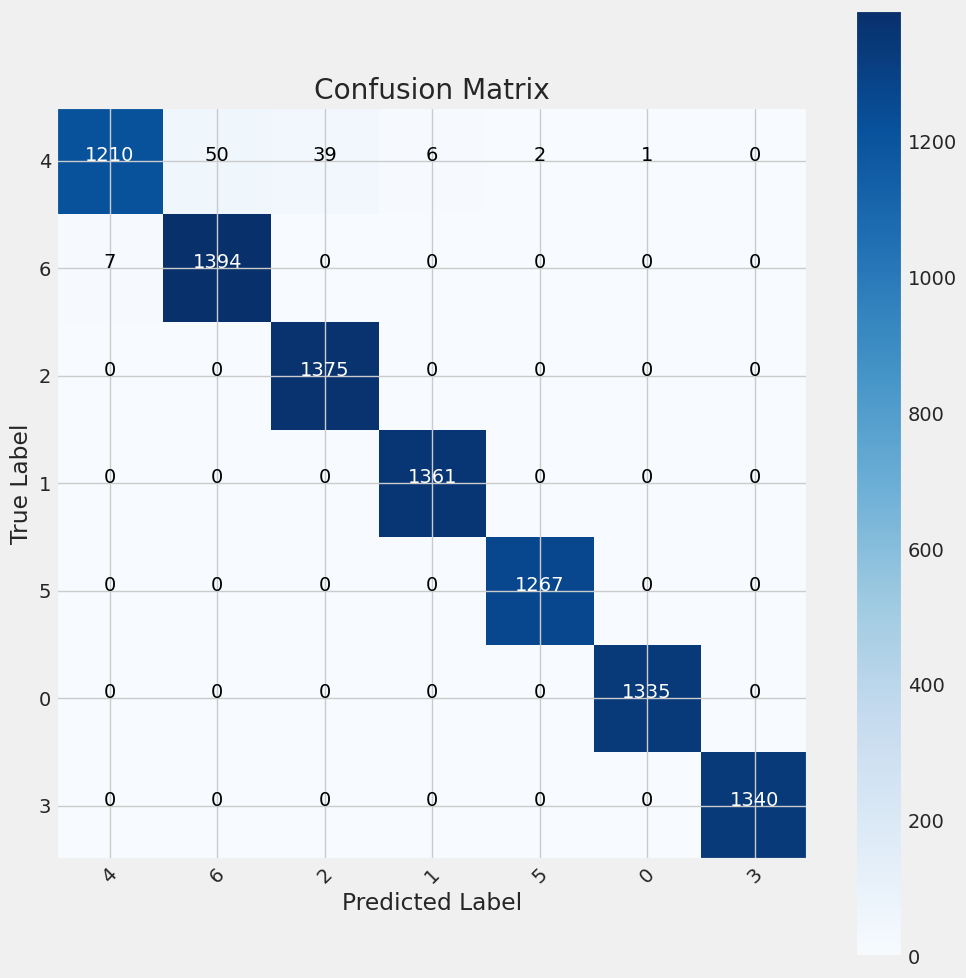

In [ ]:
# Confusion matrix
cm = cm = confusion_matrix(y_true, y_pred, labels=classes_labels)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Convert the Keras model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Write the converted model to a .tflite file
with open("model.tflite", 'wb') as f:
    f.write(tflite_model)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate Precision, Recall, and F1-Score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')


In [ ]:
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Accuracy: 0.99
Precision: 0.99
Recall: 0.99
F1-Score: 0.99


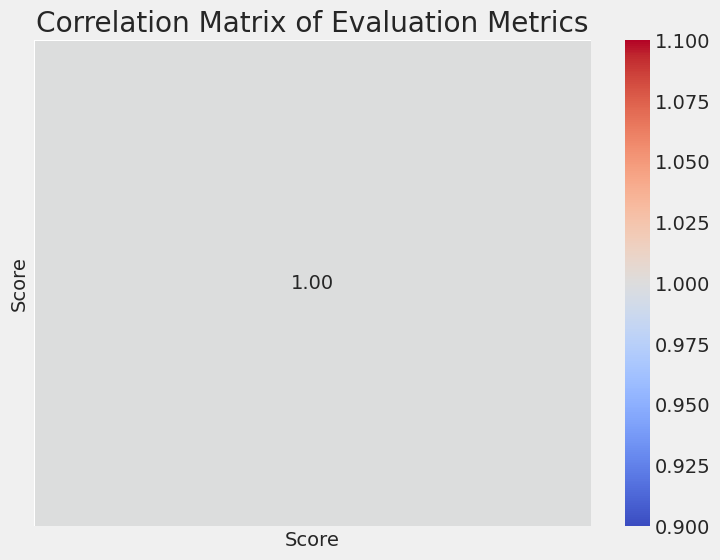

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame for the evaluation metrics
metrics_df = pd.DataFrame({'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
                            'Score': [accuracy, precision, recall, f1]})

# Create a correlation matrix
correlation_matrix = metrics_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Evaluation Metrics')
plt.show()
